<a href="https://colab.research.google.com/github/Youhanna-Yousry/Network-Anomaly-Detection/blob/master/NetworkAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Anomaly Detection


## Problem statement
The exponential growth of network traffic has led to an increase in network
anomalies, such as cyber attacks, network failures, and hardware malfunctions.
Network anomaly detection is a critical task for maintaining the security and
stability of computer networks. The objective of this assignment is to help
students understand how K-Means and Normalized Cut algorithms can be used
for network anomaly detection.. [assignment link](https://github.com/Youhanna-Yousry/Network-Anomaly-Detection/blob/master/assets/CSE352_Assignment_2.pdf)

## Imports

In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

from scipy.linalg import eigh
from scipy.spatial.distance import cdist

import math

In [ ]:
np.random.seed(42)

## 1.Downloading the Datset and Understanding the Format
This dataset contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.


*   kddcup.data.gz &rarr; Full dataset
*   kddcup.data_10_percent.gz &rarr; 10 percent subset
*   corrected.gz &rarr; Test data with corrected labels

The dataset contains 42 columns (41 for features and the last one contains the labels) for the features description check [this link](https://www.researchgate.net/figure/The-41-features-provided-by-the-KDD-Cup-99-datasets_tbl1_263274883)


[KDD Cup 1999 dataset link](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

[Files description source](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data)


In [ ]:
%%bash
# downloading datasets
gdown https://drive.google.com/uc?id=1SXEg2dIC3jAT-_8-GCJDC2wDCfGnSwoU
gdown  https://drive.google.com/uc?id=1wcr6o0ZV-OYvyaqMG1shlHsekv50lvI6
gdown https://drive.google.com/uc?id=1SBIoHv2cyf5-jHCQK48r4F1upGCbxN9p

# creating a new directory for datasets
mkdir /datasets

# unzipping datasets
gunzip -c kddcup.data.gz > /datasets/kddcup.data.corrected
gunzip -c kddcup.data_10_percent.gz > /datasets/kddcup.data_10_percent_corrected
gunzip -c corrected.gz > /datasets/corrected

Downloading...
From: https://drive.google.com/uc?id=1SXEg2dIC3jAT-_8-GCJDC2wDCfGnSwoU
To: /content/kddcup.data.gz
100%|██████████| 18.1M/18.1M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wcr6o0ZV-OYvyaqMG1shlHsekv50lvI6
To: /content/kddcup.data_10_percent.gz
100%|██████████| 2.14M/2.14M [00:00<00:00, 52.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SBIoHv2cyf5-jHCQK48r4F1upGCbxN9p
To: /content/corrected.gz
100%|██████████| 1.41M/1.41M [00:00<00:00, 62.4MB/s]
mkdir: cannot create directory ‘/datasets’: File exists


The csv files are read and saved in dataframes then every categorical column (1, 2, 41) are converted to numerical using a dictionary and a counter; if the categorical value doesn't exist in the dictionray, its numerical value becomes the current value of the counter and the counter is incremented by one. Otherwise, the categorical value is replaced by the corresponding numerical value in the dictionary.
For the sack of consistency, a dictionary is created that contains all the 3 dictionaries of the categrical columns in order to make the given numerical value the same for all the 3 dataframes.

In [ ]:
# reading dataset files and saving it in a dataframe
df = pd.read_csv('/datasets/kddcup.data.corrected', header=None)
reduced_df = pd.read_csv('/datasets/kddcup.data_10_percent_corrected', header=None)
testing_df = pd.read_csv('/datasets/corrected', header=None)

In [ ]:
def convert_categorical_columns(df, dictionaries={}):
  # getting the indexes of categorical columns
  categorical_columns = []
  for column in df.columns:
    if df[column].dtype == object:
      categorical_columns.append(column)

  # converting each one of these column to numberical data
  for column in categorical_columns:
    dictionary = {}
    if column in dictionaries:
      dictionary = dictionaries[column]

    new_column = []
    counter = len(dictionary)

    for data_point in df[column]:
      if data_point not in dictionary:
        dictionary[data_point] = counter
        counter += 1
      new_column.append(dictionary[data_point])

    dictionaries[column] = dictionary
    df[column] = new_column

  return dictionaries

In [ ]:
# converting categorical columns to numerical
dictionaries = convert_categorical_columns(df)
_ = convert_categorical_columns(reduced_df, dictionaries)
_ = convert_categorical_columns(testing_df, dictionaries)

{}
{1: {'tcp': 0, 'udp': 1, 'icmp': 2}, 2: {'http': 0, 'smtp': 1, 'domain_u': 2, 'auth': 3, 'finger': 4, 'telnet': 5, 'eco_i': 6, 'ftp': 7, 'ntp_u': 8, 'ecr_i': 9, 'other': 10, 'urp_i': 11, 'private': 12, 'pop_3': 13, 'ftp_data': 14, 'netstat': 15, 'daytime': 16, 'ssh': 17, 'echo': 18, 'time': 19, 'name': 20, 'whois': 21, 'domain': 22, 'mtp': 23, 'gopher': 24, 'remote_job': 25, 'rje': 26, 'ctf': 27, 'supdup': 28, 'link': 29, 'systat': 30, 'discard': 31, 'X11': 32, 'shell': 33, 'login': 34, 'imap4': 35, 'nntp': 36, 'uucp': 37, 'pm_dump': 38, 'IRC': 39, 'Z39_50': 40, 'netbios_dgm': 41, 'ldap': 42, 'sunrpc': 43, 'courier': 44, 'exec': 45, 'bgp': 46, 'csnet_ns': 47, 'http_443': 48, 'klogin': 49, 'printer': 50, 'netbios_ssn': 51, 'pop_2': 52, 'nnsp': 53, 'efs': 54, 'hostnames': 55, 'uucp_path': 56, 'sql_net': 57, 'vmnet': 58, 'iso_tsap': 59, 'netbios_ns': 60, 'kshell': 61, 'urh_i': 62, 'http_2784': 63, 'harvest': 64, 'aol': 65, 'tftp_u': 66, 'http_8001': 67, 'tim_i': 68, 'red_i': 69}, 3: {'

In [ ]:
# converting dataframes to numpy arrays
D = df.to_numpy()
reduced_D = reduced_df.to_numpy()
testing__D = testing_df.to_numpy()

# splitting labels from data
data = D[:, :-1]
labels = D[:, -1]

reduced_data = reduced_D[:, :-1]
reduced_labels = reduced_D[:, -1]

testing_data = testing__D[:, :-1]
testing_labels = testing__D[:, -1]

# freeing up some memory
del df, reduced_df, testing_df, D, reduced_D, testing__D, dictionaries

## 2.Clustering Using K-Means

It's objective is to find clustering that mininmize the Sum of Squared Error in each cluster

**complexity**

O(knd):
1. k: Number of clusters
2. n: size of dataset
3. d: dimensionality of data


**Advantages**


Fast algoithm

**Disadvantages**

1. May fail in non-spherical shape data
2. Can't be applied with non-numerical data
3. Choice of K is crucial
4. May stuck at local minimum and require random restarts

In [ ]:
class KMeans:
  def __init__(self):
    self.__centroids = None

  def __initialize_centroids(self, training_data, k):
    n = training_data.shape[0]
    centroids = []
    centroids_set = set()

    while len(centroids) < k:
      idx = np.random.randint(0, n)
      if tuple(training_data[idx]) in centroids_set:
        continue
      centroids.append(training_data[idx])
      centroids_set.add(tuple(training_data[idx]))

    return np.array(centroids)

  def __compute_clusters_indices(self, training_data, k, centroids):
    distances = cdist(training_data, centroids, 'sqeuclidean')
    return np.argmin(distances, axis=1)

  def __assign_clusters(self, training_data, k, centroids):
    clusters = [[] for _ in range(k)]
    min_dist_indices = self.__compute_clusters_indices(training_data, k,
                                                       centroids)

    for i, min_dist_index in enumerate(min_dist_indices):
        clusters[min_dist_index].append(training_data[i])

    return clusters

  def __update_centroids(self, training_data, clusters):
    new_centroids = []
    n = training_data.shape[0]

    for cluster in clusters:
      if len(cluster) == 0:
        new_centroids.append(training_data[np.random.randint(0, n)])
        continue
      new_centroids.append(np.mean(np.array(cluster), axis=0))

    return np.array(new_centroids)

  def __kMeans(self, training_data, k, threshold, n_iterations):
      t = 0
      centroids = self.__initialize_centroids(training_data, k)
      clusters = []

      while True:
        t += 1

        # Cluster Assignment Step
        clusters = self.__assign_clusters(training_data, k, centroids)

        # Centroid Update Step
        new_centroids = self.__update_centroids(training_data, clusters)

        if np.sum(np.sum((centroids - new_centroids)**2, axis=1)) <= threshold \
          or t == n_iterations:
          break

        centroids = new_centroids

      return clusters, centroids

  def __print_clusters_info(self, k, clusters):
    print(f'for k={k}:')
    cluster_sizes = sorted([len(cluster) for cluster in clusters], reverse=True)
    print(f'Clusters sizes: {cluster_sizes}')

  def __compute_sse(self, clusters, centroids):
    sse = 0.0

    for idx, cluster in enumerate(clusters):
      for data_point in cluster:
        sse += np.sum((data_point - centroids[idx])**2)

    return sse

  def fit(self, training_data, k, threshold=0.000001, n_iterations=100, restarts=3):
    r = 0
    min_sse = float('inf')
    best_clusters = []

    while r < restarts:
      r += 1

      clusters, centroids = self.__kMeans(training_data, k, threshold, n_iterations)
      sse = self.__compute_sse(clusters, centroids)

      if sse < min_sse:
        self.__centroids = centroids
        min_sse = sse
        best_clusters = clusters

    self.__print_clusters_info(k, best_clusters)

  def predict(self, testing_data):
    if self.__centroids is None:
      raise ValueError("KMeans object needs to be fitted first!")

    return self.__compute_clusters_indices(testing_data,
                                           self.__centroids.shape[0],
                                           self.__centroids)
  def get_centroids(self):
    return self.__centroids

In [ ]:
k_values = [7, 15, 23, 31, 45]
kmeans_dict = dict()

In [ ]:
for k in k_values:
  kmeans_dict[k] = KMeans()
  kmeans_dict[k].fit(reduced_data, k, n_iterations=300)

for k=7:
Clusters sizes: [491482, 2341, 82, 76, 21, 18, 1]
for k=15:
Clusters sizes: [290814, 184541, 10173, 3369, 2340, 1883, 574, 124, 82, 55, 24, 18, 17, 6, 1]
for k=23:
Clusters sizes: [236973, 161996, 52793, 21273, 7199, 3622, 3365, 2310, 1425, 1246, 739, 573, 235, 82, 62, 35, 27, 20, 18, 12, 10, 5, 1]
for k=31:
Clusters sizes: [235418, 143064, 52799, 24227, 13323, 5713, 4089, 3087, 2522, 2271, 1329, 1278, 1143, 955, 748, 738, 489, 209, 200, 106, 82, 74, 41, 40, 18, 17, 13, 12, 10, 5, 1]
for k=45:
Clusters sizes: [227839, 57131, 33986, 30318, 30031, 29604, 12653, 10453, 7519, 7064, 6626, 5806, 5118, 4468, 3868, 3264, 2612, 2543, 2271, 1990, 1299, 1179, 1018, 903, 852, 620, 577, 557, 487, 436, 266, 200, 105, 82, 74, 45, 41, 40, 18, 17, 13, 12, 10, 5, 1]


## 3.Clustering Using Normalized Cut

0.15% of the dataset are used for training

In [ ]:
training_data, _, training_labels, _ = train_test_split(data, labels, train_size=0.0015, stratify=labels)

The code performs eigen-decomposition on the Laplacian matrix to obtain The first smallest k eigenvectors that is after normalized. The normalized eigenvectors are then used as input to a KMeans clustering algorithm to obtain the final cluster labels.


In [ ]:
def normalized_cut(D, k, g):
  # calculating the similarity matrix A
  laplacian_matrix = rbf_kernel(D, gamma=g)

  # calculating the Degree matrix Δ
  deg_matrix = np.diag(np.sum(laplacian_matrix, axis=1))

  # calculating the Laplacian matrix L = Δ - A
  laplacian_matrix = deg_matrix - laplacian_matrix

  # calculating the Inverse Degree matrix Δ ^ -1
  #inv_deg_matrix = np.diag(1.0 / rows_sum)

  # eigendecomposition
  eigen_values, eigen_vectors = eigh(laplacian_matrix, b=deg_matrix)

  # sorting eigen values and eigen vectors
  idx = np.argsort(eigen_values)
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:, idx]

  # taking the first k eigen vectors
  U = eigen_vectors[:, :k]

  # computing norm of each row
  norms = np.linalg.norm(U, axis=1, keepdims=True) + np.finfo(float).eps

  # normalization
  Y = U / norms

  kmeans = KMeans()

  kmeans.fit(Y, k)

  return kmeans.predict(Y), Y, kmeans.get_centroids()

In [ ]:
normalized_cut(training_data, 11, 0.1)

for k=11:
Clusters sizes: [3902, 1628, 970, 208, 149, 125, 104, 97, 57, 54, 53]


 # New Clustering Algorithm (Your implementation)



# DBSCAN

DBSCAN is a clustering algorithm that has the ability to find arbitrary shape clusters and can be used for anomaly detection.

It's main idea is that it add a new point to a cluster if it is close to many points of that cluster.

**Advantages**

1. Doesn't require specifying the number of clusters in advance
2. Work with arbitrary shape data
3. Can detect anomalies

**Cons**

1. Require hyperparameters tunining


**Parameters**

1. Data: data points to be clustered
2. eps: The distance used two define a neighbourhood between two points
3. min_samples: The minimum number of neighbours to define a core point

**Definitions**

1. Core point: it is a point that has at least min_samples in its neighbourhood
2. Border point: don't have the min number of samples but reachable from core point
3. Outlier: Neither Core point nor Border point

**Steps**

1. Firstly, We start with any data point and mark it as visited.
2. After that we check if the point has at least min_samples in its neighbourhood.
3. If so, we start cluster creation by adding all its neighbours to a cluster. If not we mark it as a noise.
4. For all the points we added to the cluster we check the number of their neighbours.
5.  If it is at least min_samples, then we add all its neighbours to the same cluster and repeat the process.
6. If not we just add the neighbour point without its neighbours.
7. repeat the process untill all points are visited.

**Datastructure used**

Ball Tree:

The ball tree is constructed by recursively partitioning the data points into nested hyper-spheres.

It is efficient when the number of dimensions is large and the number of data points is also large.

In [ ]:
def create_cluster(clusters, cluster_idx, data, root, neighbours, eps, min_samples, visited, tree):

  clusters[root] = cluster_idx
  visited[root, 1] = True

  while len(neighbours) > 0:

   nighbour = neighbours.pop(0)

   if not visited[nighbour, 0]:
      visited[nighbour, 0] = True
      new_neighbours = tree.query_radius([data[nighbour]], r=eps)

      if len(new_neighbours[0]) >= min_samples:
        neighbours = list(set(neighbours) | set(new_neighbours[0]))

   if not visited[nighbour, 1]:
     clusters[nighbour] = cluster_idx
     visited[nighbour, 1] = True

In [ ]:
from sklearn.neighbors import BallTree

def DBSCAN(data, eps, min_samples):

    tree = BallTree(data)

    visited = np.array([[False, False] for i in range(len(data))])
    clusters, cluster_idx = np.zeros(len(data)), 0

    for i in range(len(data)):
        if visited[i, 0]:
            continue

        visited[i,0] = True

        neighbours = tree.query_radius([data[i]], r=eps)


        if len(neighbours[0]) >= min_samples:
            create_cluster(clusters, cluster_idx, data, i, list(neighbours[0]), eps, min_samples, visited, tree)
            cluster_idx = cluster_idx + 1

        else:
            clusters[i] = -1

    return clusters

In [ ]:
data = np.array([[0, 1], [0, 2], [10, 3], [11, 4], [10, 8]])
clusters = DBSCAN(training_data, 10, 41)

for x in np.unique(clusters):
  if x != -1:
    print(len(clusters[clusters == x]))

826
3375
639
536
289
62


# Evaluation

In this function, we plot the evauation measure agaiinst the number of clusters for the training data and test data.

In [ ]:
def draw_fig(k_values, training_measures, test_measures, measure_name):
  plt.plot(k_values, training_measures, 'o-', label='training')
  plt.plot(k_values, test_measures, 'o-',  label='testing')
  plt.legend()

  plt.xlabel('K')
  plt.ylabel(measure_name)
  plt.title(f'{measure_name} & K relationship')

  plt.show()

**Precision**

In this function, we count the frequency of labels in each cluster, then we define the precision of a cluster to be the ratio between the frequency of the label with highest majority to the size of the cluster. Then we compute purity as weighted avergare of the sum of all precisions for all clusters


In [ ]:
def prec(clusters, labels):
    i = 0
    clusters_len = len(np.unique(clusters)) if -1 not in clusters else len(np.unique(clusters))-1
    total_len = len(clusters[clusters != -1])
    precisions = np.zeros(clusters_len)
    purity = 0

    for x in np.unique(clusters):
        if x == -1:
          continue
        cluster = np.where(np.array(clusters) == x)[0]
        label_counts = {}
        for point in cluster:

            point_label = labels[point]

            value = label_counts.setdefault(point_label, 0)
            label_counts[point_label] = value + 1

        max_label_count = max(label_counts.values())
        precisions[i] = max_label_count / len(cluster)
        purity += precisions[i] * len(cluster) / total_len
        i += 1

    return precisions, purity

**Recall**

In this function, we count the frequency of labels in each cluster, then we define the recall of a cluster to be the ratio between the frequency of the label with highest majority to the total label counts in all clusters. Then we compute recall as the avergare of all computed recalls from all clusters

In [ ]:
def rec(clusters, labels):

    i = 0
    clusters_len = len(np.unique(clusters)) if -1 not in clusters else len(np.unique(clusters))-1
    recalls = np.zeros(clusters_len)

    total_label_counts = {}
    for x in np.unique(clusters):
        if x == -1:
          continue
        cluster = np.where(np.array(clusters) == x)[0]
        for point in cluster:

            point_label = labels[point]

            value = total_label_counts.setdefault(point_label, 0)
            total_label_counts[point_label] = value + 1

    for x in np.unique(clusters):
        if x == -1:
          continue
        cluster = np.where(np.array(clusters) == x)[0]
        label_counts = {}
        for point in cluster:

            point_label = labels[point]

            value = label_counts.setdefault(point_label, 0)
            label_counts[point_label] = value + 1

        max_label_count = max(label_counts.values())
        max_key = [k for k, v in label_counts.items() if v == max_label_count][0]
        recalls[i] = max_label_count / total_label_counts[max_key]
        i += 1

    return recalls, np.sum(recalls) / clusters_len

**F1-Score**


For each cluster, we comute the Fmeasure = 2 * precision * recall / ( precision + recall), then we compute the F1-Score as the average of the    Fmeasure for all clusters

In [ ]:
def f1(prec, rec):
  return np.sum(2*prec*rec / (prec + rec)) / len(prec)

**Conditional Entropy**

In this function, we store the label of each point in all clusters, then we iterate for each cluster and compute its conditional entropy to equal the summation of -1 * nij / ni * log(nij / ni).

where:


1. nij is the count of label j in cluster i

2. ni is the size of cluster i.

Finally, we compute the conditional entropy to equal the weighted average of the conditional entropy of each cluster.

In [ ]:
def conditional_entropy(clusters, labels):

  unique_labels = np.unique(labels)
  labels_clusters = []

  for x in np.unique(clusters):
        if x == -1:
          continue
        cluster = np.where(np.array(clusters) == x)[0]
        labels_list = []
        for point in cluster:
            labels_list.append(labels[point])
        labels_clusters.append(labels_list)

  H_C = []
  for cluster in labels_clusters:
    H_Ci = 0
    for label in unique_labels:
      cluster = np.array(cluster)
      n = len(cluster[cluster == label])
      H_Ci += 0 if n == 0 else -n / len(cluster) * math.log(n / len(cluster), 2)

    H_C.append(len(cluster) / len(clusters[clusters != -1]) * H_Ci)

  return np.sum(H_C)

**Compute Anomalies**

This function is used to count the number of anomalies in the resulted clustering.

It find the majority label in each cluster then consider all remaining points that have different label as anomalies

Finally, it count the number of anomalies in each cluster then return it

In [ ]:
def compute_anomalies(clusters, labels):

    anomalies = 0

    for x in np.unique(clusters):
        if x == -1:
          continue
        cluster = np.where(np.array(clusters) == x)[0]
        label_counts = {}
        for point in cluster:

            point_label = labels[point]

            value = label_counts.setdefault(point_label, 0)
            label_counts[point_label] = value + 1

        max_label = max(label_counts, key=label_counts.get)
        cluster_labels = np.array(labels[cluster])
        anomalies += len(cluster_labels[cluster_labels != max_label])

    return anomalies

This function takes the clusters and labels as pararmeters and compute the 4 evaluation measures for them

In [ ]:
def evaluation_measures(clusters, labels):
  precision, purity = prec(clusters, labels)
  print("Purity", purity)

  recalls, recall = rec(clusters, labels)
  print("recall", recall)

  f1_score = f1(precision, recalls)
  print("F1 Score", f1_score)

  entropy = conditional_entropy(clusters, labels)
  print("Conditional Entropy", entropy)


**Kmeans Evaluations**

Here we compute the four evaluation measures for K-means for both training and testing data and we can notice the following:

1. We can see that for the purity measure as K increase the purity increases and this is because this measurement prefer clusters with no confusion and as the number of cluster increases their size decreases and also the confusion in each cluster decrease so the purity increases.

2. For the recall measure as it is the ratio between the count of label in cluster and the total label count, we can notice that as K increase the number of clusters increase and their size decrease so as well the label count in each cluster will decrease so finally the average recall decrease.

3. As F1-score penalize clusters that have low recall or prcision we can see that as K increases the F1-score decreases.

4. Also from the definition of Entropy, it prefers low confiusion in clusters so we can notice that because as the number of clusters increases the confusion decreases, the entropy value decreases i.e get better

In [ ]:
kmeans_purities = []
kmeans_recalls = []
kmeans_f1_scores = []
kmeans_entropies = []

for k in k_values:
  prec1, purity1 = prec(kmeans_dict[k].predict(reduced_data), reduced_labels)
  prec2, purity2 = prec(kmeans_dict[k].predict(testing_data), testing_labels)

  kmeans_purities.append([purity1, purity2])

  rec1, recall1 = rec(kmeans_dict[k].predict(reduced_data), reduced_labels)
  rec2, recall2 = rec(kmeans_dict[k].predict(testing_data), testing_labels)

  kmeans_recalls.append([recall1, recall2])

  f1_score1 = f1(prec1, rec1)
  f1_score2 = f1(prec2, rec2)

  kmeans_f1_scores.append([f1_score1, f1_score2])

  entropy1 = conditional_entropy(kmeans_dict[k].predict(reduced_data), reduced_labels)
  entropy2 = conditional_entropy(kmeans_dict[k].predict(testing_data), testing_labels)

  kmeans_entropies.append([entropy1, entropy2])

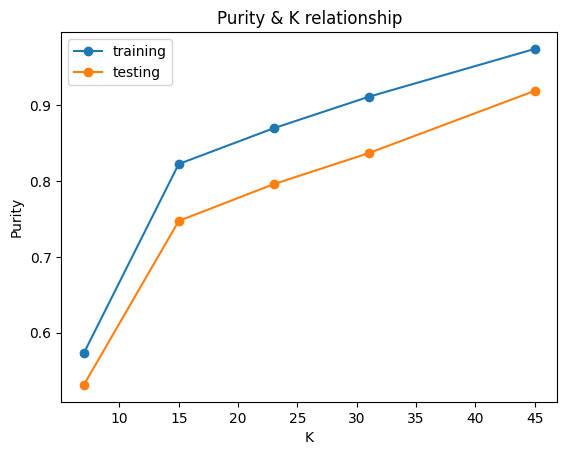

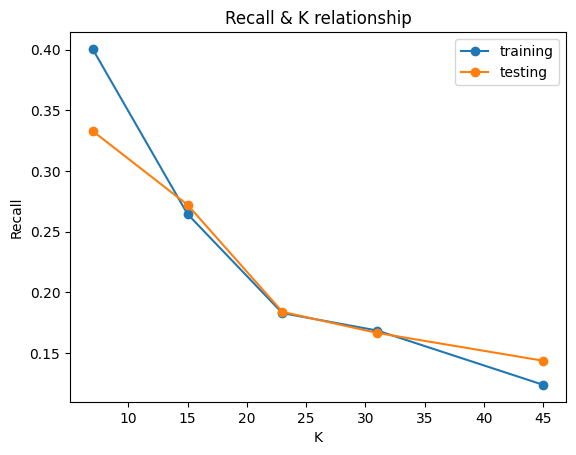

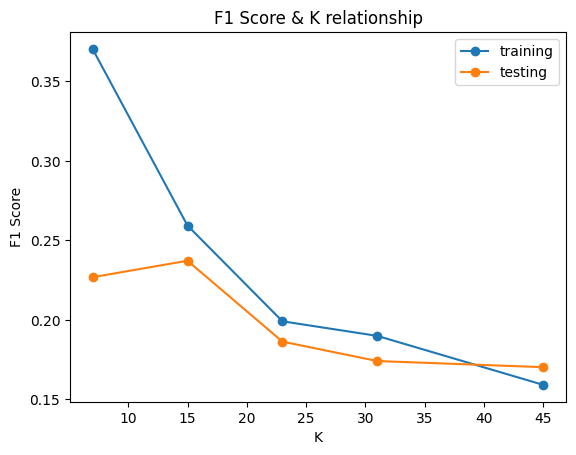

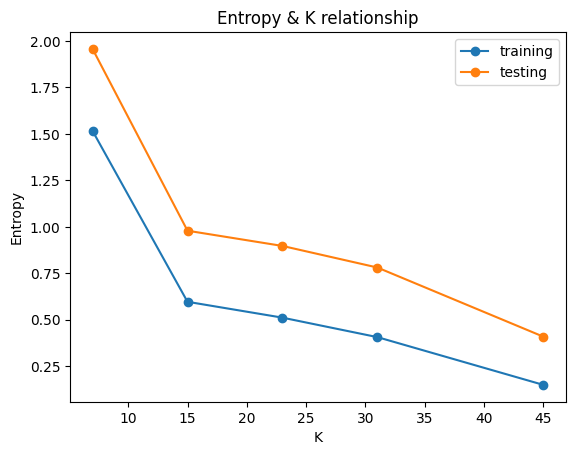

In [ ]:
draw_fig(k_values, np.array(kmeans_purities)[:,0], np.array(kmeans_purities)[:,1], 'Purity')
draw_fig(k_values, np.array(kmeans_recalls)[:,0], np.array(kmeans_recalls)[:,1], 'Recall')
draw_fig(k_values, np.array(kmeans_f1_scores)[:,0], np.array(kmeans_f1_scores)[:,1], 'F1 Score')
draw_fig(k_values, np.array(kmeans_entropies)[:,0], np.array(kmeans_entropies)[:,1], 'Entropy')

We can see from that resulted evaluation measures that:

DBSCAN is best clustering algorithm for this dataset
Kmeans is the least performance algorithm

There are many anomalies in Kmeans compared to Normalized cut

The reason for that is Kmeans has some cons:
1. It is not efficient with non-spherical shaped data
2. It may stuck at local minimum


In [ ]:
kmeans = KMeans()
kmeans.fit(training_data, 11, n_iterations=300)

clusters = kmeans.predict(training_data)

evaluation_measures(clusters, training_labels)

for k=11:
Clusters sizes: [3537, 2623, 804, 210, 100, 27, 18, 18, 6, 3, 1]
Purity 0.8436096365863618
recall 0.29615552370864234
F1 Score 0.281455557040079
Conditional Entropy 0.5200634005464979


In [ ]:
compute_anomalies(clusters, training_labels)

1149

Normalized-Cut Evaluations

In [ ]:
clusters, new_training_data, centroids = normalized_cut(training_data, 11, 0.1)

evaluation_measures(clusters, training_labels)

for k=11:
Clusters sizes: [3397, 1703, 874, 704, 171, 159, 144, 102, 70, 22, 1]
Purity 0.9670613855995644
recall 0.2623662342531199
F1 Score 0.3258569054115065
Conditional Entropy 0.19751924308702254


In [ ]:
compute_anomalies(clusters, training_labels)

242

DBSCAN Evaluations

In [ ]:
clusters = DBSCAN(training_data, 10, 41)

evaluation_measures(clusters, training_labels)

Purity 0.9994761655316919
recall 0.5
F1 Score 0.595634868767147
Conditional Entropy 0.0057662175129444306
